In [1]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import torch
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
os.makedirs('img_res', exist_ok=True) #creates a folder to store the loss graphs
os.makedirs('test_res', exist_ok=True) #creates a folder to store the files of the testing of the model
import functions as f #import functions used to plot

In [3]:
#I found a warning regarding the key names for energy and forces, the label changes from 'energy' to 'REF_energy'
input_file = "Fe_Si_B_1118.xyz"
output_file = "Fe_Si_B_1118_fixed.xyz"

with open(input_file, "r") as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # Fix energy key in header lines
    if "energy=" in line:
        line = line.replace("energy=", "REF_energy=")
    # Fix forces key in Properties line
    if "Properties=" in line and "forces" in line:
        line = line.replace("forces", "REF_forces")
    new_lines.append(line)

# Write the fixed file
with open(output_file, "w") as f:
    f.writelines(new_lines)

In [ ]:
read_data = read('Fe_Si_B_1118_fixed.xyz', index=':')
db_data = [(a.info['REF_energy']) for a in read_data]
df = pd.DataFrame(db_data, columns=['REF_energy'])
df = df[3:] #here I am using only the configurations that are not isolated atoms
df

,REF_energy
3,-127.219750
4,-127.107488
5,-127.897006
6,-128.718378
7,-127.140738
...,...
1283,-360.155006
1284,-358.164922
1285,-359.691319
1286,-352.753314


(array([789., 159.,   0.,   0.,   0.,   0.,   0.,  51., 282.,   4.]),
 array([-386.84585546, -354.20900438, -321.57215329, -288.93530221,
        -256.29845112, -223.66160004, -191.02474896, -158.38789787,
        -125.75104679,  -93.1141957 ,  -60.47734462]),
 <BarContainer object of 10 artists>)

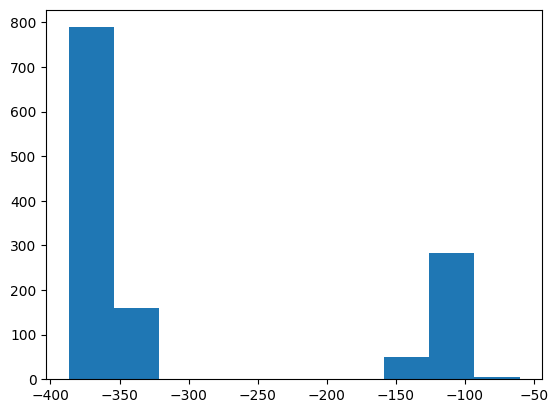

In [10]:
plt.hist(df)

In [11]:
#importing the full data (this is in case I have like the whole data in one file)
db = read('Fe_Si_B_1118_fixed.xyz', ':')

In [12]:
#splitting the data into the training and test sets
# I am using 80% of the data for training and the remaining will be the test data
write('train_01.xyz', db[:1031])
write('test_01.xyz', db[1031:])

In [13]:
#setting the model name based on model number and epochs
device = 'cpu'
''' model_num:
    1 -> this indicates the model using 250 training data
    2 -> this indicates the model using 520 training data which is 80% of the data set
    3,4 -> this indicates the model using different values of learning rate 0.005, 0.0001 '''
model_id = 'scaleshift_lr0.001'
#model_id = 'mace_lr0.0001'
#model_num = 4
''' num_epochs:
    sets the number of epochs used for running the trainig'''
num_epoch = 25
''' batch_size:
    sets the batch size for training'''
batch_size = 25
''' model_name:
    generates the name of the model based on the number of epochs and the model number using the 'model_num' variable '''
model_name = f'model_{model_id}_{num_epoch}epochs_{batch_size}batch'
model_name

'model_scaleshift_lr0.001_25epochs_25batch'

In [14]:
#this writes the yml file
config = {
    "model": "ScaleShiftMACE",
    #"model": "MACE",
    "num_channels": 32,
    "max_L": 0,
    "r_max": 4.0,
    "name": model_name,
    "train_file": f"train_01.xyz",
    "valid_fraction": 0.01,
    "test_file": f"test_01.xyz",
    "energy_key": "REF_energy",
    "forces_key": "REF_forces",
    "batch_size": batch_size,
    "max_num_epochs": num_epoch,
    "optimizer" : "adam",
    "lr":0.001,
    "device": device,
    "seed": 123,
    'config_type_weights': {'highE': 0.2}
}
with open("config_new_model.yml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

In [15]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') # use the name of the config file that was created

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
2025-11-11 22:39:23.342 INFO: ===========VERIFYING SETTINGS===========
2025-11-11 22:39:23.342 INFO: MACE version: 0.3.14
2025-11-11 22:39:23.343 INFO: Using CPU
2025-11-11 22:39:23.417 INFO: ===========LOADING INPUT DATA===========
2025-11-11 22:39:23.418 INFO: Using heads: ['Default']
2025-11-11 22:39:23.418 INFO: Using the key specifications to parse data:
2025-11-11 22:39:23.419 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-11-11 22:39:23.419 INFO: =============    Processing head Default     ===========
2025-11-11 22:39:23.587 INFO: Using isolated atom energies from training file
2025-1

In [16]:
#reading the information on the results file
results = f'results/{model_name}_run-123_train.txt' #reading the file where the training results is stored
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [17]:
results

'results/model_scaleshift_lr0.001_25epochs_25batch_run-123_train.txt'

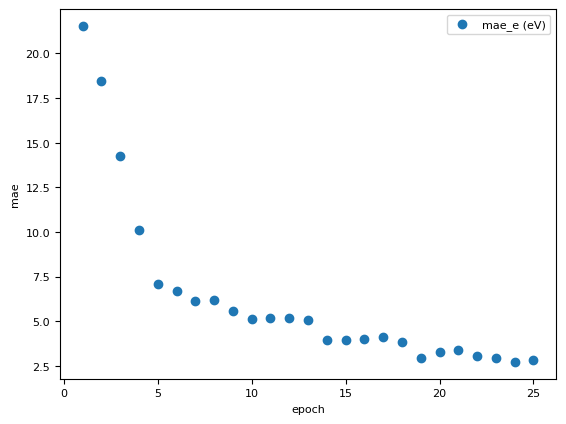

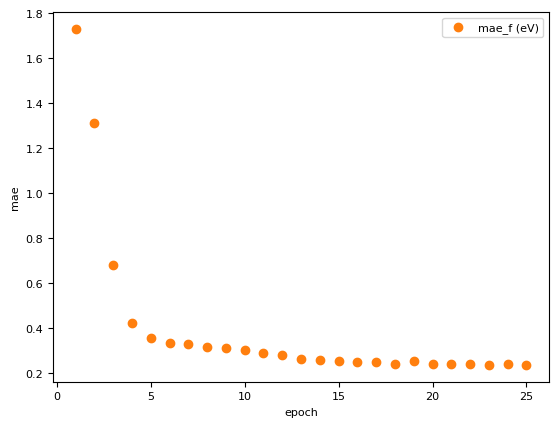

In [18]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy().dropna()
#train_df = train_df.groupby('epoch', as_index=False)['loss'].last()
train_df = train_df.groupby('epoch', as_index=False)['loss'].mean()
train_df['epoch'] += 1
val_df['epoch'] += 1

#plotting the dataframe
import functions as f
f.plot_mae(val_df, 'epoch', ['mae_e','mae_f'])

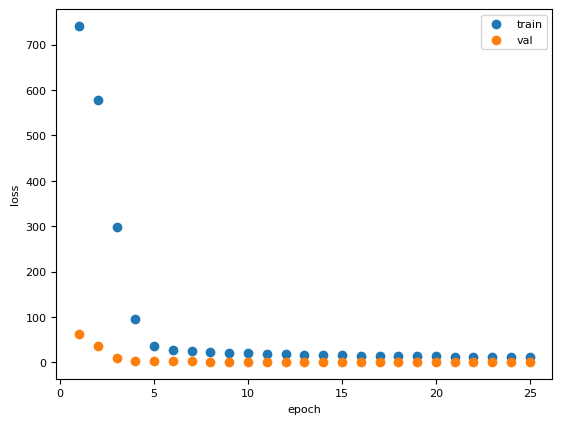

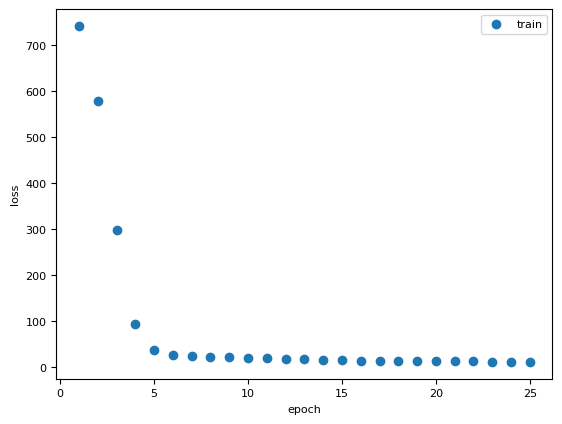

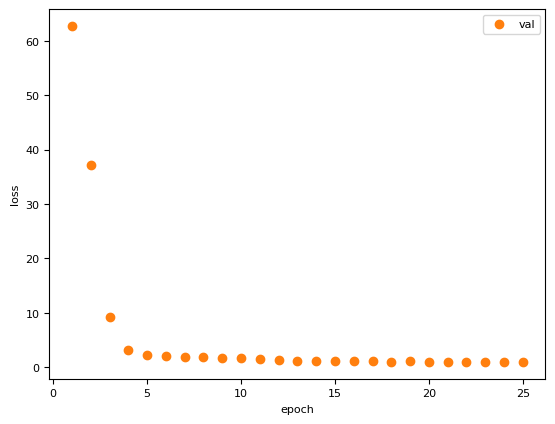

In [19]:
#plotting the validation and loss error
f.plot_loss([(train_df, 'train'),(val_df,'val')],'epoch','loss',model_name)

In [20]:
#the model can be evaluated using this
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(model, configs, output, device=device):
    sys.argv=['program', '--configs', configs, '--model', model, '--output', output, '--device', device]
    mace_eval_configs_main()

In [25]:
#evaluating the set on both the training and test datasets
eval_mace(model=f'{model_name}.model',
          configs='train_01.xyz',
          output=f'test_res/{model_name}_train.xyz')

eval_mace(model=f'{model_name}.model',
          configs='test_01.xyz',
          output=f'test_res/{model_name}_test.xyz')

2025-11-11 23:15:28.250 INFO: Using CPU
2025-11-11 23:15:41.681 INFO: Using CPU


In [ ]:
from ase.io import read

#importing data from the evaluation of the test set
#read the configurations with the mace predictions
res_list = read(f'test_res/{model_name}_test.xyz', index=':')
#extracting the reference and mace energies
res = [(a.info['REF_energy'], a.info['MACE_energy']) for a in res_list]
df_res = pd.DataFrame(res, columns=['REF_energy', 'MACE_energy'])
df_res

,REF_energy,MACE_energy
0,-363.255521,-361.662555
1,-358.184535,-357.267814
2,-360.245577,-357.930396
3,-365.225759,-363.713928
4,-364.798772,-363.366081
...,...,...
252,-360.155006,-358.638723
253,-358.164922,-356.802764
254,-359.691319,-358.712444
255,-352.753314,-352.089038


In [ ]:
#importing data from the evaluation of the training set
train_list = read(f'test_res/{model_name}_train.xyz', index=':')
train_res = [(a.info['REF_energy'], a.info['MACE_energy']) for a in train_list]
df_train = pd.DataFrame(train_res, columns=['REF_energy', 'MACE_energy'])
df_train

,REF_energy,MACE_energy
0,-3.382082,-7.310409
1,-0.466087,-4.994344
2,-0.870355,-5.875925
3,-127.219750,-126.346867
4,-127.107488,-126.367307
...,...,...
1026,-356.726300,-356.203673
1027,-362.688013,-361.937776
1028,-352.060176,-350.453161
1029,-356.431248,-355.197636


In [23]:
#saving to an excel file so that we can keep a register of how different the resuls are for the different models
df_res.to_excel(f'test_res/{model_name}_test.xlsx')

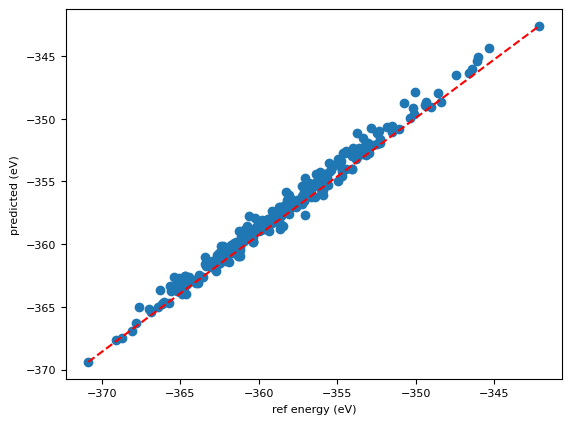

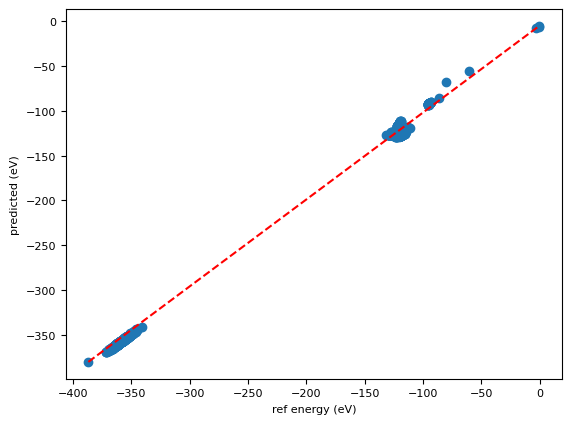

In [34]:
f.plot_energy_comparison(df_res, 'REF_energy', 'MACE_energy')
f.plot_energy_comparison(df_train, 'REF_energy', 'MACE_energy')